In [25]:
from datetime import datetime, timedelta
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
datelist = pd.date_range(datetime.today(), periods=100).tolist()
from time import sleep
import dask.dataframe as dd
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
import os
import glob
from datetime import date

from uuid import uuid4


import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import geopandas as gpd
import seaborn as sns

import dask.dataframe as dd
import geopandas as gpd
from detect_heatwaves import detect
from datetime import timedelta
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt



In [26]:
full_df = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/THI/brazil/daily_max_THI.csv')

full_df.rename(columns={'time': 'datetime'}, inplace=True)
full_df['datetime'] = pd.to_datetime(full_df['datetime'])
full_df['day'] = pd.DatetimeIndex(full_df['datetime']).day
full_df['month'] = pd.DatetimeIndex(full_df['datetime']).month
full_df['year'] = pd.DatetimeIndex(full_df['datetime']).year
full_df.month.unique()
full_df = full_df[~full_df['month'].isin([9, 10, 4])]

full_df['location'] = full_df['adm2'] + ', ' + full_df['adm1']
full_df['datetime_ord'] = [date(x,y,z).toordinal() for x,y,z in zip(full_df['year'], full_df['month'], full_df['day'])]


In [27]:
full_df['datetime'].max()

Timestamp('2022-03-31 00:00:00')

In [28]:
full_df['location'].value_counts().value_counts()

756    5571
Name: location, dtype: int64

## Find heat waves, heat wave lengths and assign unique heatwave IDs

In [29]:
full_df['datetime'].min()

Timestamp('2017-11-01 00:00:00')

In [30]:
full_df['datetime'].min()

Timestamp('2017-11-01 00:00:00')

In [31]:
full_df['pct'] = full_df.groupby('location')['thi'].transform(lambda x: x.rank(pct=True))

In [32]:
full_df

,Unnamed: 0,datetime,number,spatial_ref,t2m,d2m,rh,thi,adm2,adm1,day,month,year,location,datetime_ord,pct
32,32,2017-11-01,0.0,0.0,30.754091,23.699919,99.284130,34.536635,Alta Floresta D'Oeste,Rondonia,1,11,2017,"Alta Floresta D'Oeste, Rondonia",736634,0.576720
33,33,2017-11-02,0.0,0.0,30.176624,24.412321,99.309520,34.206450,Alta Floresta D'Oeste,Rondonia,2,11,2017,"Alta Floresta D'Oeste, Rondonia",736635,0.534392
34,34,2017-11-03,0.0,0.0,32.247883,23.842026,96.945560,36.116240,Alta Floresta D'Oeste,Rondonia,3,11,2017,"Alta Floresta D'Oeste, Rondonia",736636,0.834656
35,35,2017-11-04,0.0,0.0,32.057150,24.055305,92.948490,36.534109,Alta Floresta D'Oeste,Rondonia,4,11,2017,"Alta Floresta D'Oeste, Rondonia",736637,0.888889
36,36,2017-11-05,0.0,0.0,32.395805,24.450556,95.430040,35.896920,Alta Floresta D'Oeste,Rondonia,5,11,2017,"Alta Floresta D'Oeste, Rondonia",736638,0.794974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5130885,5130885,2022-03-27,0.0,0.0,28.232721,17.985998,83.782776,28.516208,Brasilia,Distrito Federal,27,3,2022,"Brasilia, Distrito Federal",738241,0.620370
5130886,5130886,2022-03-28,0.0,0.0,29.747370,17.164396,82.518040,29.150807,Brasilia,Distrito Federal,28,3,2022,"Brasilia, Distrito Federal",738242,0.775132
5130887,5130887,2022-03-29,0.0,0.0,29.235947,16.837595,80.469986,28.723406,Brasilia,Distrito Federal,29,3,2022,"Brasilia, Distrito Federal",738243,0.679894
5130888,5130888,2022-03-30,0.0,0.0,29.165964,16.901367,78.179140,28.607756,Brasilia,Distrito Federal,30,3,2022,"Brasilia, Distrito Federal",738244,0.641534


In [33]:
#create dictionary containing each county's heatwave periods
heatwave_dic = {}
for adm2 in full_df['location'].unique():
    adm2_df = full_df[(full_df['location'] == adm2)]
    adm2_df.reset_index(inplace=True)
    adm2_df = adm2_df.sort_values(by='datetime')
    adm2_df.drop_duplicates(['adm2', 'datetime'], inplace=True)
    heatwave_dic[adm2] = detect(adm2_df['datetime_ord'].values, adm2_df['thi'].values, pctile=90, minDuration=2)

    
heatwave_dates = {}
consec_dates = {}
heatwave_IDs = {}
for adm2 in heatwave_dic.keys(): 
    consec_dates[adm2] = {}
    heatwave_dates[adm2] = []
    heatwave_IDs[adm2] = {}


    heatwave_starts = heatwave_dic[adm2]['date_start']
    heatwave_ends = heatwave_dic[adm2]['date_end']
    for i in range(len(heatwave_starts)):
        heatwave_code = str(uuid4())
        heatwave_days = pd.date_range(heatwave_starts[i],heatwave_ends[i],freq='d')
        length_heatwaves = len(heatwave_days)
        consec_dates[adm2][heatwave_days[0]] = length_heatwaves
        for item in heatwave_days:
            heatwave_dates[adm2].append(item)
            heatwave_IDs[adm2][item] = heatwave_code
            
            
heat_df = pd.DataFrame.from_dict(heatwave_dates, orient='index').unstack().reset_index()
heat_df.rename(columns={'level_1':'location', 0:'datetime'}, inplace=True)


heat_df.dropna(inplace=True)
heat_df['heatwave']=1

In [34]:
full_df = full_df.merge(heat_df, on=['location', 'datetime'], how='left')

full_df['heatwave'] = full_df['heatwave'].replace(np.nan, 0)

In [35]:
full_df[full_df['heatwave'] == 1]['pct'].min()

0.9007936507936508

In [36]:
full_df['pct'] = full_df.groupby('location')['thi'].transform(lambda x: x.rank(pct=True))

In [37]:
len(full_df[full_df['heatwave'] == 1]['location'].unique())

5569

In [38]:
codes = pd.DataFrame.from_dict(heatwave_IDs, orient='index').unstack().reset_index()

In [39]:
codes.columns=['datetime', 'location', 'heat_ID']

In [40]:
codes.dropna(inplace=True)

In [41]:
consec = pd.DataFrame.from_dict(consec_dates, orient='index').unstack().reset_index()

In [42]:
consec.columns= ['datetime', 'location', 'Heat Wave Duration']

In [43]:
consec.dropna(inplace=True)

In [46]:
full_df = full_df.merge(codes, on=['datetime', 'location'])

In [47]:
full_df = full_df.merge(consec, on=['datetime', 'location'], how='left')

In [49]:
full_df['heat_ID'].value_counts()

cf3d375c-4830-4d5b-bd21-423aec69ce0b    22
fb6d4084-250b-4919-afe4-d9a96c02e33d    22
eb52543f-9836-48da-ac9f-d751dbe5ee4e    22
239dd38d-eb7d-44d1-a8bf-3bd2b544f9be    17
0d5a6e82-214b-416d-94ec-65a30fa14fef    17
                                        ..
57e74505-3da7-46d5-a038-e43b8cb7b5dd     2
fd50c624-bf9e-45eb-b5d4-b59f85351bef     2
7efbc03c-9533-4d7f-b941-7a729e615ba7     2
f83bcfec-7667-4e16-b649-4e5d4af86770     2
ae1b6003-f5cb-4acc-8b57-64bbc805a80e     2
Name: heat_ID, Length: 94263, dtype: int64

In [51]:
full_2022 = full_df[full_df['datetime'] >= '2021-10-01']

In [52]:
len(full_2022['adm2'].unique())

3460

In [53]:
gdf = gpd.read_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/adm0_shp/brazil/clean_shp.shp')

In [55]:
for_plot = gdf.merge(full_df.groupby(['adm2', 'adm1'])['thi'].mean().reset_index(), left_on=['adm2', 'adm1'], right_on=['adm2', 'adm1'])

Text(0.5, 1.0, 'Brazil 2018-2022 heatwave temperatures (C)')

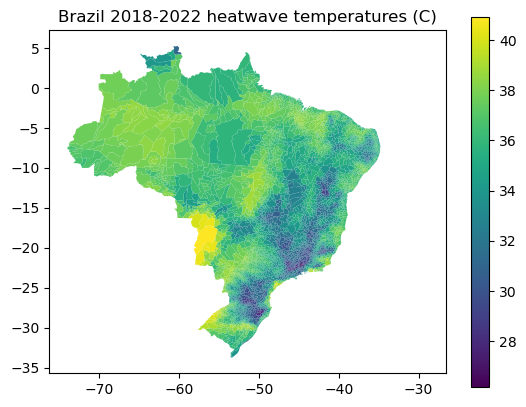

In [57]:
for_plot.plot(column='thi', legend=True)
plt.title("Brazil 2018-2022 heatwave temperatures (C)")

In [59]:
#changed from v2
full_2022.to_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/brazil/THI_brazil_90_2022.csv')
full_df.to_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/brazil/THI_brazil_90_2018_2022.csv')